# Goal

Test transforms

Thanks to: fastAI, FAIMED3D
-  https://github.com/kbressem/faimed3d/blob/main/faimed3d/augment.py#L515
-  https://github.com/fastai/fastai/blob/master/fastai/vision/augment.py#L21

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Data Augs
from transforms import AddChannel, Iso, PadSz, MattAff, PiecewiseHistScaling, \
                       ZScale, GNoise, GBlur, \
                       RandBright, RandContrast, RandDihedral, MattAff


# Helper functions
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange
from helpers.viz        import viz_axis, viz_compare_inputs, get_mid_idx

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Utilities
import os
import sys
import time
import pickle
from pathlib import Path

# Input IO
import SimpleITK as sitk

# Numpy and Pytprch
import torch
import numpy as np

# Fastai
from fastai import *
from fastai.basics import *

# Get data

In [4]:
def get_batch(tls, bs=1):
    dls = tls.dataloaders(bs=1, after_batch=batch_tfms, num_workers=2)
    return dls.one_batch()

In [5]:
# Get data
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata"
label_src   = f"{data_src}/samir_labels"

# Get data dict
data = {}
folders = os.listdir(label_src)
for folder in folders: data.update(get_data_dict_n4(f"{label_src}/{folder}"))

# Convert data dict => items (path to MR, path to Segm tensor)
items = list(data.values())

In [10]:
#strange_item = [f for f in items if f[0].startswith(f"{label_src}/50002-50153/50132")]

strange_item = \
  ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50132/MP-RAGE/2000-01-01_00_00_00.0/S165256/ABIDE_50132_MRI_MP-RAGE_br_raw_20120830221747048_S165256_I329266_corrected_n4.nii',
  '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50132/seg.pt')

In [34]:
worst_item, best_item = [
    ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50327/MP-RAGE/2000-01-01_00_00_00.0/S165359/ABIDE_50327_MRI_MP-RAGE_br_raw_20120830231312523_S165359_I329369_corrected_n4.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50327/seg.pt'),
    ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50130/MP-RAGE/2000-01-01_00_00_00.0/S164626/ABIDE_50130_MRI_MP-RAGE_br_raw_20120830173031456_S164626_I328634_corrected_n4.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153/50130/seg.pt')
]

In [6]:
# orientation: ('RAS' or 'RAI' or 'RPS' or 'RPI' or 'LAS' or 'LAI' or
#           'LPS' or 'LPI' or 'RSA' or 'RSP' or 'RIA' or 'RIP' or 'LSA' or
#           'LSP' or 'LIA' or 'LIP' or 'ARS' or 'ARI' or 'ALS' or 'ALI' or
#           'PRS' or 'PRI' or 'PLS' or 'PLI' or 'ASR' or 'ASL' or 'AIR' or
#           'AIL' or 'PSR' or 'PSL' or 'PIR' or 'PIL' or 'SRA' or 'SRP' or
#           'SLA' or 'SLP' or 'IRA' or 'IRP' or 'ILA' or 'ILP' or 'SAR' or
#           'SAL' or 'SPR' or 'SPL' or 'IAR' or 'IAL' or 'IPR' or 'IPL',
#           nipype default value: RAS)

In [18]:
import nibabel as nb
from nibabel.orientations import inv_ornt_aff

# https://github.com/nipy/nipype/blob/70add2941679146307a5bd0769358fc8bcdff17c/nipype/interfaces/image.py#L110
from nibabel.orientations import (
            axcodes2ornt, ornt_transform, inv_ornt_aff)


In [19]:
# nb.apply_orientation??

In [20]:
# https://theaisummer.com/medical-image-coordinates/#affine-transformation
# https://github.com/nipy/nipype/blob/70add2941679146307a5bd0769358fc8bcdff17c/nipype/interfaces/image.py#L110

import nibabel as nb
from nibabel.orientations import inv_ornt_aff

def get_affine(from_code, to_code, im):
    orig_ornt = axcodes2ornt(from_code)
    targ_ornt = axcodes2ornt(to_code)
    transform = ornt_transform(orig_ornt, targ_ornt)
    affine_xfm = inv_ornt_aff(transform, im.shape)
    
    # apply
    t_arr   = nb.apply_orientation(im, transform)
    new_aff = affine_xfm.dot(inv_ornt_aff(transform, im.shape))
    #reoriented = img.__class__(t_arr, new_aff, img.header)
    
    return t_arr

In [21]:
class Ori(ItemTransform):
    def __init__(self, from_code, to_code):
        self.from_code = from_code
        self.to_code   = to_code
    def encodes(self, x):
        im, mk = x
        return get_affine(self.from_code, self.to_code, im), \
               get_affine(self.from_code, self.to_code, mk)
        

In [22]:
import scipy
def transform_coordinate_space(modality_1, modality_2):
    """
    Transfers coordinate space from modality_2 to modality_1
    Input images are in nifty/nibabel format (.nii or .nii.gz)
    """
    aff_t1 = make_affine(modality_1, False) #modality_1.affine
    aff_t2 = make_affine(modality_2, False)#modality_2.affine
    inv_af_2 = np.linalg.inv(aff_t2)
    out_shape = modality_1.get_fdata().shape

    # desired transformation
    T = inv_af_2.dot(aff_t1)

    # apply transformation
    transformed_img = scipy.ndimage.affine_transform(modality_2.get_fdata(), T, output_shape=out_shape)

    return transformed_img

In [23]:
def make_affine(simpleITKImage, ras_adj):
    # get affine transform in LPS
    c = [simpleITKImage.TransformIndexToPhysicalPoint(p)
         for p in ((1, 0, 0),
                   (0, 1, 0),
                   (0, 0, 1),
                   (0, 0, 0))]
    c = np.array(c)
    affine = np.concatenate([
        np.concatenate([c[0:3] - c[3:], c[3:]], axis=0),
        [[0.], [0.], [0.], [1.]]
    ], axis=1)
    affine = np.transpose(affine)
    # convert to RAS to match nibabel
    if ras_adj:
        affine = np.matmul(np.diag([-1., -1., 1., 1.]), affine)
    return affine

In [24]:
# https://github.com/nipy/nipype/blob/70add2941679146307a5bd0769358fc8bcdff17c/nipype/interfaces/image.py#L110
from nibabel.orientations import (
            axcodes2ornt, ornt_transform, inv_ornt_aff)


In [25]:
class IsoOri(ItemTransform):
    split_idx = None
    
    def __init__(self, new_sp = 3, ori="LAS"):
        self.new_sp = new_sp
        self.new_ori = ori
        
    def encodes(self, x):
        # get sitk objs
        im_path, segm_path = x
        
        # mr obj
        mr = sitk.ReadImage(im_path, sitk.sitkFloat32)
        
        # mk obj
        mk_arr = torch.load(f"{str(Path(segm_path).parent)}/seg.pt").float()
        mk = sitk.GetImageFromArray(mk_arr)
        mk.SetDirection(mr.GetDirection())
        
        # reorient
        im = sitk.DICOMOrient(mr, self.new_ori)
        mk = sitk.DICOMOrient(mk, self.new_ori)
        
        # to tensor
        im = torch.transpose(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
        mk = torch.transpose(torch.tensor(sitk.GetArrayFromImage(mk)), 0, 2).float()
        
        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        while im.ndim < 5: 
            im = im.unsqueeze(0)
            mk = mk.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze(), \
                F.interpolate(mk, size = new_sz, mode = 'nearest').squeeze().long()

In [26]:
c = [p
         for p in ((1, 0, 0),
                   (0, 1, 0),
                   (0, 0, 1),
                   (0, 0, 0))]
c = np.array(c)
affine = np.concatenate([
    np.concatenate([c[0:3] - c[3:], c[3:]], axis=0),
    [[0.], [0.], [0.], [1.]]
], axis=1)

In [27]:
np.matmul(np.diag([-1., -1., 1., 1.]), affine)

array([[-1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [28]:
# Seg2mask
def seg2mask(image_obj, segm_obj, ras_adj):
    dims = image_obj.GetSize()
    aff     = make_affine(image_obj, ras_adj)
    idx_pts = np.indices(dims[::-1], dtype=np.uint16).T.reshape(-1,3)[:,[2,1,0]]
    physical_pts = (np.dot(aff[:3,:3], idx_pts.T) + aff[:3,3:4]).T 
    return (Delaunay(segm_obj.points).find_simplex(physical_pts) >= 0).reshape(dims)

In [29]:
class IsoOri(ItemTransform):
    split_idx = None
    
    def __init__(self, new_sp = 3, ori="LAS"):
        self.new_sp = new_sp
        self.new_ori = ori
        
    def encodes(self, x):
        # get sitk objs
        im_path, segm_path = x
        
        # mr obj
        mr = sitk.ReadImage(im_path, sitk.sitkFloat32)
        
        # mk obj
        mk_arr = torch.load(f"{str(Path(segm_path).parent)}/seg.pt").float()
        mk = sitk.GetImageFromArray(mk_arr)
        mk.SetDirection(mr.GetDirection())
        
        # reorient
        im = sitk.DICOMOrient(mr, self.new_ori)
        mk = sitk.DICOMOrient(mk, self.new_ori)
        
        # to tensor
        im = torch.transpose(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
        mk = torch.transpose(torch.tensor(sitk.GetArrayFromImage(mk)), 0, 2).float()
        
        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        while im.ndim < 5: 
            im = im.unsqueeze(0)
            mk = mk.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze(), \
                F.interpolate(mk, size = new_sz, mode = 'nearest').squeeze().long()

In [30]:
from matplotlib import gridspec
    
def plot_mid_slices(x, y, ax, no_ticks=True):
    bbox = mask2bbox(y)
    mids = get_mid_idx(bbox)
    for i in range(3):
        ax[i].imshow(np.rot90(np.take(x, mids[i], axis=i)), cmap=plt.cm.gray)
        ax[i].imshow(np.rot90(np.take(y, mids[i], axis=i)), alpha=0.50)
        
        if no_ticks:
            ax[i].set_xticks([])
            ax[i].set_yticks([])

def get_gridspec(nrows, ncols, wspace=0.0, hspace=0.0, fig_mult=1.):
    fig = plt.figure(figsize=(fig_mult*(ncols+1), fig_mult*(nrows+1))) 
    gs  = gridspec.GridSpec(nrows, ncols,
    wspace=wspace, hspace=hspace, 
    top=1.-0.5/(nrows+1), bottom=0.5/(nrows+1), 
    left=0.5/(ncols+1), right=1-0.5/(ncols+1)) 
    return fig, gs
    
def viz_compare_ori(item, oris = ["LAS", "SRA", "RAS", "SLA"]):
    # param
    iso_sz = 2
    maxs   = [144, 144, 144]
    
    # figure
    n = len(oris)
    
    fig, gs = get_gridspec(nrows=3, ncols=n)
    axes = np.array([[plt.subplot(gs[row,col]) for col in range(n)] for row in range(3)])
    
    for i,ori in enumerate(oris):

        x,y = Pipeline([Iso(iso_sz), PadSz(maxs), Ori("LAS", ori)], split_idx=0)(item)
        x = np.asarray(x)
        y = np.asarray(y)
        plot_mid_slices(x,y, axes[:,i], no_ticks=i!=0)
        
    plt.plot()

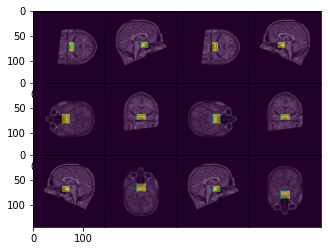

In [86]:
viz_compare_ori(worst_item)

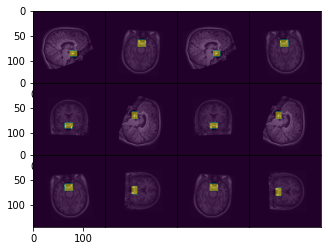

In [87]:
viz_compare_ori(best_item)

In [32]:
class OriNotSeg(ItemTransform):
    def __init__(self, from_code, to_code):
        self.from_code = from_code
        self.to_code   = to_code
    def encodes(self, x):
        im, mk = x
        return get_affine(self.from_code, self.to_code, im), \
               get_affine(self.from_code, self.from_code, mk)

def viz_compare_ori_not_seg(item, oris = ["LAS", "SRA", "RAS", "SLA"]):
    # param
    iso_sz = 2
    maxs   = [144, 144, 144]
    
    # figure
    n = len(oris)
    
    fig, gs = get_gridspec(nrows=3, ncols=n)
    axes = np.array([[plt.subplot(gs[row,col]) for col in range(n)] for row in range(3)])
    
    for i,ori in enumerate(oris):

        x,y = Pipeline([Iso(iso_sz), PadSz(maxs), OriNotSeg("LAS", ori)], split_idx=0)(item)
        x = np.asarray(x)
        y = np.asarray(y)
        plot_mid_slices(x,y, axes[:,i], no_ticks=i!=0)
        
    plt.plot()

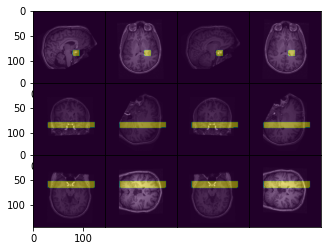

In [36]:
viz_compare_ori_not_seg(strange_item)

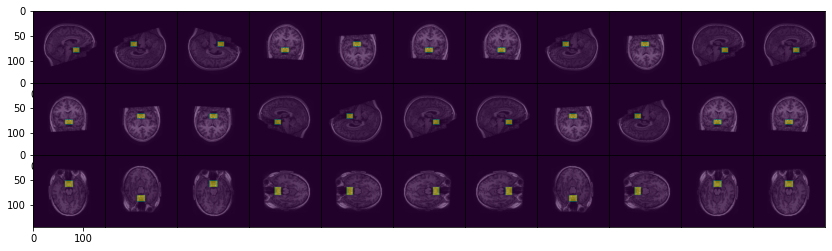

In [125]:
viz_compare_aug(orig_batch, Pipeline([ZScale(), RandDihedral(p=1.0), AddChannel()], split_idx=0), n=10)

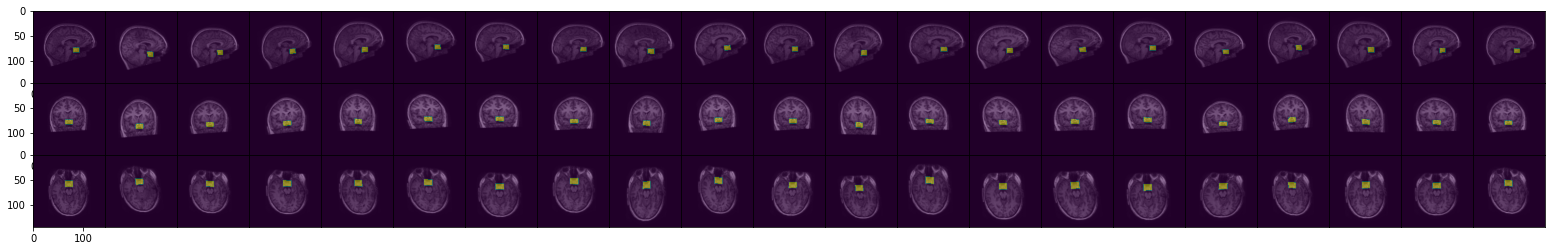

In [128]:
viz_compare_aug(orig_batch, Pipeline([ZScale(), MattAff(p=1.0), AddChannel()], split_idx=0), n=20)

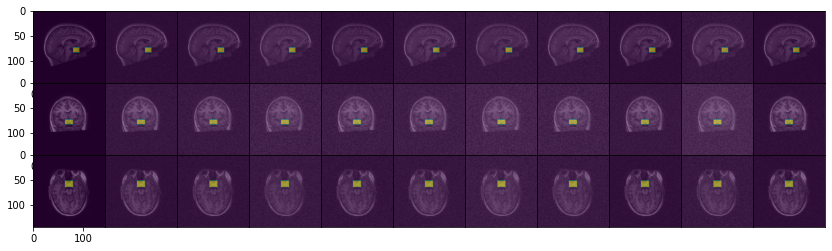

In [127]:
viz_compare_aug(orig_batch, Pipeline([ZScale(), GNoise(p=1.0), AddChannel()], split_idx=0), n=10)

# All

In [108]:
batch_tfms = [
    # normalize mean/std of foreground pixels
    ZScale(),
    # flip
    RandDihedral(p=1.),
    # noise
    GNoise(p=1., std_range=[0.01, 0.1]),
    GBlur(p=1.,  kernel_size_range=[5, 11], sigma=0.5),
    AddChannel(),
    # affine
    MattAff(p=1., strength=0.05)
]

In [114]:
Pipeline(batch_tfms, split_idx=0)

Pipeline: ZScale -> RandDihedral -> GNoise -> GBlur -> AddChannel -- {} -> MattAff

torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144])
torch.Size([1, 1, 144, 144, 144]) torch.Size([1,

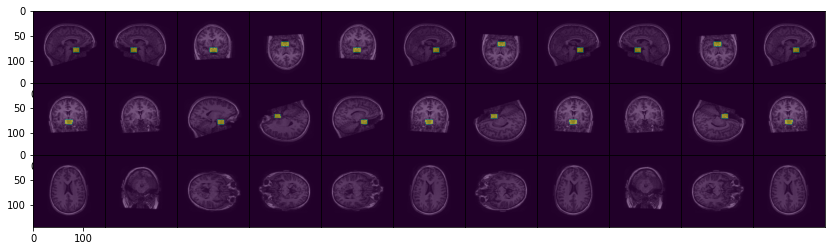

In [119]:
viz_compare_aug(orig_batch, Pipeline([ZScale(), RandDihedral(p=1.0)], split_idx=0), n=10)

In [6]:
im_path, seg_path = items[0]
mr = sitk.ReadImage(im_path, sitk.sitkFloat32)
im = torch.transpose(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)

In [7]:
# transform params
iso       = 2
maxs      = [144, 144, 144]

In [8]:
item_subset = items[0:5]

# item tfms
item_tfms  = [Iso(iso), PadSz(maxs)]
tls = TfmdLists(item_subset, item_tfms)

# test Z scale
dls = tls.dataloaders(bs=2, after_batch=[], num_workers=2)
z_dls = tls.dataloaders(bs=2, after_batch=[ZScale()], num_workers=2)

# batch
orig_xb,orig_yb      = dls.one_batch()
z_orig_xb, z_orig_yb = z_dls.one_batch()

print(orig_xb.size(), orig_yb.size())

torch.Size([2, 144, 144, 144]) torch.Size([2, 144, 144, 144])


In [11]:
# z aug
def get_stats(im):
    mask = im > im.mean()
        
    # rescale
    mean = im[mask].mean()
    std  = im[mask].std()
    
    return mean, std

# test aug
def test_aug(aug, do_viz = True, idx = 0, orig_xb=z_orig_xb, orig_yb = z_orig_yb):    
    b = (orig_xb, orig_yb)

    # do aug
    print(len(b), b[0].size(), b[1].size()) 
    aug_xb, aug_yb = aug(b)
    
    # viz 1 in batch     
    x,y, aug_x, aug_y = [a[idx].cpu() for a in (orig_xb, orig_yb, aug_xb, aug_yb)]
    
    if do_viz: viz_compare((x,y), (aug_x, aug_y))
    
    return x,y, aug_x,aug_y

# test Affine

torch.Size([2, 1, 144, 144, 144]) torch.Size([2, 1, 144, 144, 144])
(tensor(2.1944e-08, device='cuda:0'), tensor(1.0000, device='cuda:0'))
2 torch.Size([2, 1, 144, 144, 144]) torch.Size([2, 1, 144, 144, 144])
torch.Size([1, 144, 144, 144]) torch.Size([1, 144, 144, 144]) torch.Size([1, 144, 144, 144]) torch.Size([1, 144, 144, 144])
1: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.
2: 
Bbox coords: (67, 64, 69) to (85, 77, 80). Size: 18, 13, 11.
Bounding box coord: from location (64, 69) of slice 67 to location (77, 80) of slice 85.


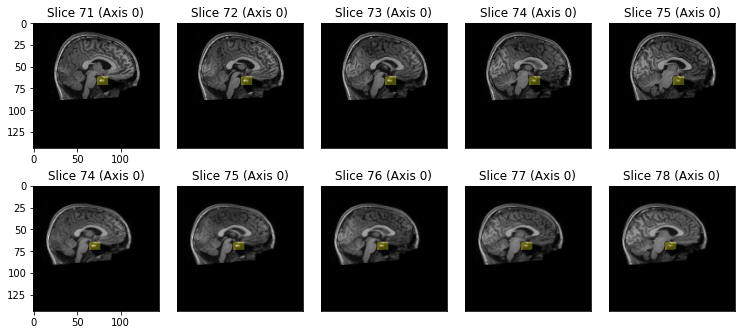

In [14]:
# test Matt Affine
dls2 = tls.dataloaders(bs=2, after_batch=[ZScale(), AddChannel()], num_workers=2)

# batch
ch_orig_xb,ch_orig_yb = dls2.one_batch()
print(ch_orig_xb.size(), ch_orig_yb.size())
print(get_stats(ch_orig_xb))
r = MattAff(p=1.)
#aug_xb, aug_yb = r(()

x, y, aug_x, aug_y = test_aug(r, do_viz=False, idx=1, orig_xb=ch_orig_xb, orig_yb=ch_orig_yb)
print(x.shape, y.shape, aug_x.shape, aug_y.shape)
viz_compare((x[0],y[0]), (aug_x[0], aug_y[0]))

In [15]:
# r = RandomAffine(p=1., degrees=35, translate=0.1, scale=0.1)
# im, seg, aug_im, aug_seg = test_aug(r, split_idx = None, do_viz=True, idx=1)

# test ZScale

2 torch.Size([2, 144, 144, 144]) torch.Size([2, 144, 144, 144])
1: 
Bbox coords: (66, 74, 60) to (81, 86, 70). Size: 15, 12, 10.
Bounding box coord: from location (74, 60) of slice 66 to location (86, 70) of slice 81.
2: 
Bbox coords: (66, 74, 60) to (81, 86, 70). Size: 15, 12, 10.
Bounding box coord: from location (74, 60) of slice 66 to location (86, 70) of slice 81.


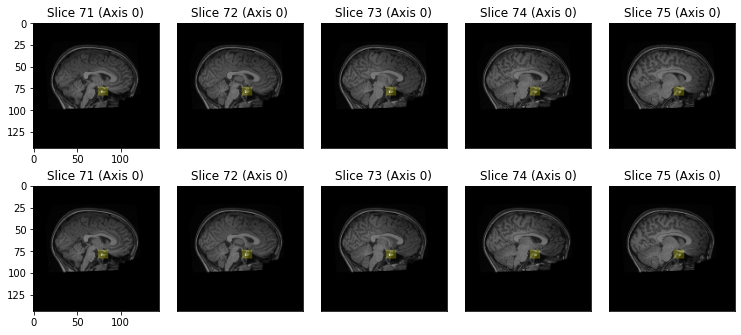

In [20]:
im, seg, aug_im, aug_seg = test_aug(ZScale(), orig_xb=orig_xb, orig_yb=orig_yb)

In [21]:
def get_stats(im):
    mask = im > im.mean()
        
    # rescale
    mean = im[mask].mean()
    std  = im[mask].std()
    
    return mean, std

In [22]:
print(get_stats(im), get_stats(aug_im))

(tensor(232.6045), tensor(118.1554)) (tensor(-0.8029), tensor(0.1552))


(array([2.685641e+06, 6.511300e+04, 8.966300e+04, 7.531600e+04,
        5.861700e+04, 1.107000e+04, 5.170000e+02, 3.800000e+01,
        6.000000e+00, 3.000000e+00]),
 array([-1.1083878 , -0.99464977, -0.8809117 , -0.7671736 , -0.6534355 ,
        -0.53969747, -0.42595938, -0.31222132, -0.19848323, -0.08474515,
         0.02899292], dtype=float32),
 <BarContainer object of 10 artists>)

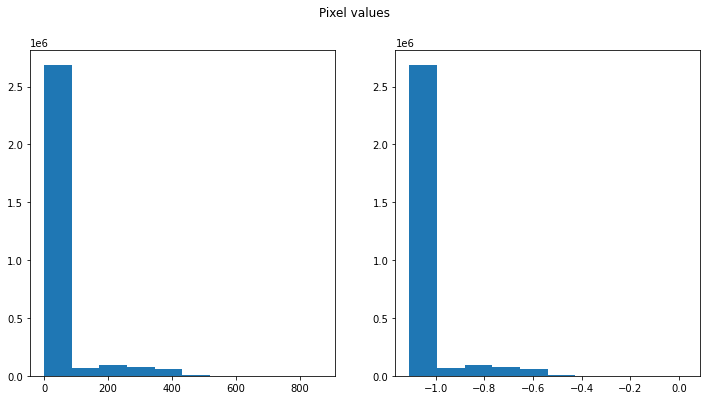

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Pixel values')
ax1.hist(np.asarray(im).ravel())
ax2.hist(np.asarray(aug_im).ravel())

# Compose

In [ ]:
batch_tfms = [
    ZScale(),
    #RandomAffine(p=0.5, degrees=35, translate=0.1, scale=0.1),
]

In [ ]:
dls2 = tls.dataloaders(bs=2, after_batch=batch_tfms, num_workers=2)
# test get one batch
b = dls2.one_batch()
print("batch type", type(b), "im shape", b[0].shape, b[1].shape)
print("dls train len ", len(dls.train), len(dls.valid))

# test RandDihedreal

2 torch.Size([2, 144, 144, 144]) torch.Size([2, 144, 144, 144])
1: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.
2: 
Bbox coords: (65, 72, 73) to (82, 82, 86). Size: 17, 10, 13.
Bounding box coord: from location (72, 73) of slice 65 to location (82, 86) of slice 82.


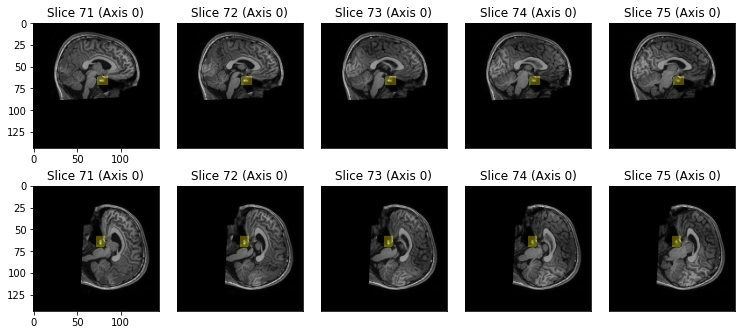

In [29]:
im, seg, aug_im, aug_seg = test_aug(RandDihedral(p=1.))

# test GNoise

2 torch.Size([2, 144, 144, 144]) torch.Size([2, 144, 144, 144])
1: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.
2: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.


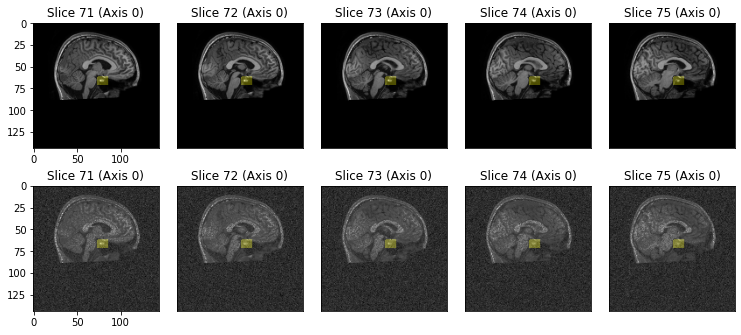

In [30]:
im, seg, aug_im, aug_seg = test_aug(GNoise(p=1., std_range=[0.1, 0.3]))

# test GBlur

2 torch.Size([2, 144, 144, 144]) torch.Size([2, 144, 144, 144])
1: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.
2: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.


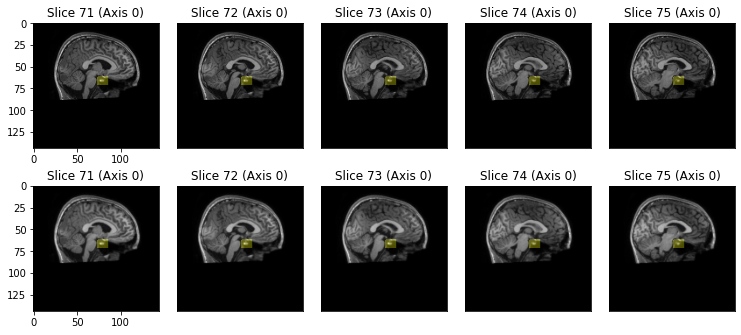

In [31]:
im, seg, aug_im, aug_seg = test_aug(GBlur(p=1.))

# test RandBright

2 torch.Size([2, 144, 144, 144]) torch.Size([2, 144, 144, 144])
1: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.
2: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.


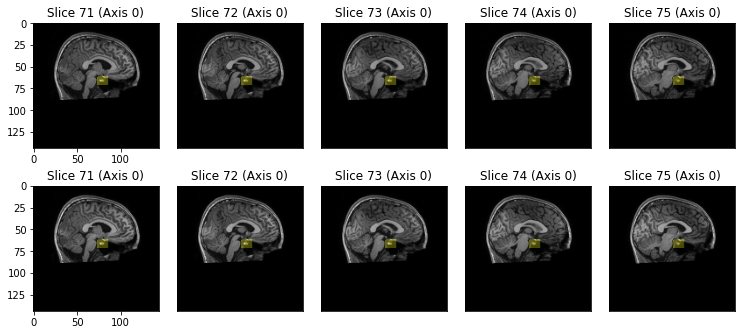

In [37]:
im, seg, aug_im, aug_seg = test_aug(RandBright(p=1., beta_range=[0.9, 1.4]))

In [38]:
im[70,75,60], aug_im[70,75,60], im[70,75,60]-aug_im[70,75,60]

(tensor(0.1991), tensor(1.0991), tensor(-0.9000))

# test RandContrast

2 torch.Size([2, 144, 144, 144]) torch.Size([2, 144, 144, 144])
a 1.2
1: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.
2: 
Bbox coords: (65, 73, 72) to (82, 86, 82). Size: 17, 13, 10.
Bounding box coord: from location (73, 72) of slice 65 to location (86, 82) of slice 82.


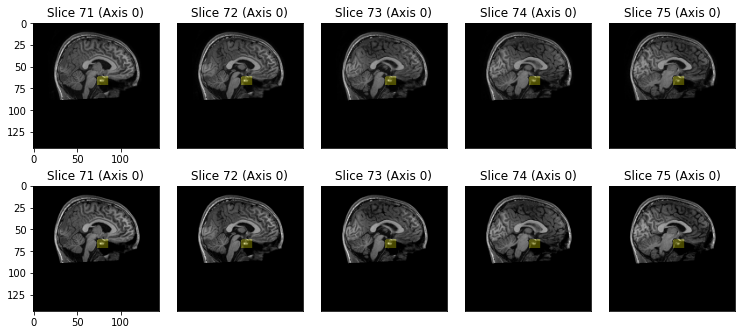

In [39]:
im, seg, aug_im, aug_seg = test_aug(RandContrast(p=1., alpha_range=[1.2, 1.3]))

In [40]:
np.array_equal(im, aug_im)

False

In [41]:
im[70,75,60], aug_im[70,75,60], im[70,75,60]/aug_im[70,75,60]

(tensor(0.1991), tensor(0.2389), tensor(0.8333))

# Load item

In [ ]:
# time it
start = time.time()

# splits
#splits = RandomSplitter(seed=42)(subset)
#print(f"Training: {len(splits[0])}, Valid: {len(splits[1])}")

# tfms
item_tfms  = [Iso(2), PadSz(maxs), PiecewiseHistScaling(landmark_percs=percs, standard_scale=standard_scale)]
batch_tfms = [AddChannel(), MattAffineTfm(0.05)]

# tls
tls = TfmdLists(items, item_tfms, splits=(train_idxs, valid_idxs))

# dls
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(train_idxs) + len(valid_idxs)} items")

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(len(dls.train), len(dls.valid))

In [ ]:
# test: viz 1 img before and after affine tfm
idx = 2
strength = 0.05

img_in, seg_in     = Pipeline(item_tfms)(items[idx])
b_img_in, b_seg_in = (img_in.unsqueeze(0), seg_in.unsqueeze(0))
img_out1, seg_out1 = AddChannel()((b_img_in, b_seg_in))
img_out2, seg_out2 = MattAffineTfm(strength=strength)((img_out1, seg_out1))

print(img_in.shape, b_img_in.shape, img_out1.shape, img_out2.shape, sep="\n")

# Viz

def viz_bbox(mr, seg):

    mr, seg = np.array(mr), np.array(seg)
    gt_bbox = mask2bbox(mr)
    
    # print bbox
    print("GT: "); print_bbox(*gt_bbox)

    bbox = gt_bbox
    
    axis0_len = bbox[1] - bbox[0]
    start_middle = bbox[0] + axis0_len//2 - 2
    end_middle = start_middle + 4
    
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = seg,     color1 = "yellow",  alpha1=0.3, \
            #bin_mask_arr2  = pred_mk, color2 = "magenta", alpha2=0.3, \
            slices=lrange(start_middle, end_middle), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

#             np_arr_b = mr, \
#             bin_mask_arr_b   = seg,     color1_b = "yellow",  alpha1_b=0.3, \
#             #bin_mask_arr2_b  = pred_mk, color2_b = "magenta", alpha2_b=0.3, \
#             slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
#             title_b  = "Axis 1", \

#             np_arr_c = mr, \
#             bin_mask_arr_c   = seg,     color1_c = "yellow",  alpha1_c=0.3, \
#             #bin_mask_arr2_c  = pred_mk, color2_c = "magenta", alpha2_c=0.3, \
#             slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
#             title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)

    

In [ ]:
viz_bbox(img_out1.squeeze(), seg_out1.squeeze())

In [ ]:
viz_bbox(img_out2.squeeze(), seg_out2.squeeze())

# Metric

Linear combination of Dice and Cross Entropy

In [ ]:
# start = time.time()

# segs = torch.cat([tl[1] for tl in dls.train],0)
# print(segs.shape)

# elapsed = time.time() - start

# print(f"Elapsed time: {elapsed} s for {len(segs)} items")

In [ ]:
# class_weight = torch.sqrt(1.0/(torch.bincount(segs.view(-1)).float()))
# class_weight = class_weight/class_weight.mean()
# class_weight[0] = 0.5
# np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
# print('inv sqrt class_weight',class_weight.data.cpu().numpy())

In [ ]:
# from utils import my_ohem

In [ ]:
# pos_weight = torch.load("saved_metadata/class_weights.pt")
# class_weights = [0, pos_weight]

# # inv
# class_weights [1.0/x for x in class_wei]
# my_criterion = my_ohem(.25,[0, pos_weight]) #.cuda())#0.25 

In [ ]:
# def obelisk_loss_fn(predict, target): return my_criterion(F.log_softmax(predict,dim=1),target)

In [ ]:
# ipython nbconvert --to python  '6 - Dataloaders- NB - Simple-Copy1.ipynb'

In [ ]:
# test

item_tfms2  = [Iso(iso), PadSz(maxs)]
batch_tfms2 = [
    # normalize mean/std of foreground pixels
    ZScale(),
    RandDihedral(p=1.),
    GNoise(p=1.),
    GBlur(p=1.),
    AddChannel(),
    MattAff(p=1.)
]

t = items[0]
input1 = Pipeline(item_tfms2)(t)
input2 = Pipeline([*item_tfms2, *batch_tfms2])(t)

# rm batch and ch dim from im,mk = input2
input2 = tuple(a.squeeze() for a in input2)
print("Shapes: ", input1[0].shape, input2[0].shape)
viz_compare(input1, input2)

# MONAI

In [ ]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import VNet

In [ ]:
# https://docs.monai.io/en/latest/networks.html#vnet

In [ ]:
device = torch.device("cuda:0")
model = VNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
).to(device)
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=False)

In [ ]:
GPUs = GPU.getGPUs()
for gpu in GPUs:
    print("GPU {0:20s} RAM Free: {1:.0f}MB | Used: {2:.0f}MB | Util {3:3.0f}% | Total {4:.0f}MB".format(gpu.name, gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [ ]:
print("Test")
xb, yb = dls.one_batch()
xb, yb = xb.cpu(), yb.cpu()

pb = model.cpu()(xb)
print(xb.shape, pb.shape)
print(f"logcosh dice loss {log_cosh_dice_loss(pb,yb)}")

# Learner

In [ ]:
# clear cache
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# print GPU stats
import GPUtil as GPU
GPUs = GPU.getGPUs()
for gpu in GPUs:
    print("GPU {0:20s} RAM Free: {1:.0f}MB | Used: {2:.0f}MB | Util {3:3.0f}% | Total {4:.0f}MB".format(gpu.name, gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [ ]:
# OBELISK-NET from github
from models import obelisk_visceral, obeliskhybrid_visceral

In [ ]:
full_res = maxs

#omodel = obeliskhybrid_visceral(num_labels=2, full_res=full_res)
#vmodel  = VNet(elu=True, nll=False)

learn = Learner(dls=dls, \
                model=model, \
                loss_func= log_cosh_dice_loss, #DiceLoss(), #log_cosh_dice_loss, #loss, #DiceLoss(), #nn.CrossEntropyLoss(), \
                metrics = dice_score, \
                model_dir = model_src, \
                cbs = [SaveModelCallback(monitor='dice_score', fname=model_name, with_opt=True)])

# SaveModelCallback: model_dir = "./models", cbs = [SaveModelCallback(monitor='dice_score')]

# GPU
learn.model = learn.model.cuda()

#learn = learn.to_distributed(args.local_rank)


In [ ]:
# # test:

# #dls.device = "cpu"

# start = time.time()

# x,y = dls.one_batch()
# #x,y = to_cpu(x), to_cpu(y)

# pred = learn.model(x)
# loss = learn.loss_func(pred, y)

# elapsed = time.time() - start

# print(f"Elapsed: {elapsed} s")
# print("Batch: x,y")
# print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

# print("Pred shape")
# print(type(pred), pred.shape, pred.dtype)

# print("Loss")
# print(loss)
# print(learn.loss_func)

# LR Finder

In [ ]:
# learn.lr_find()

In [ ]:
print("PRE learn.fit one cycle")
with learn.distrib_ctx():
    learn.fit_one_cycle(1, 3e-3, wd = 1e-4)

In [ ]:
print(f"unfreeze, learn {nepochs}")
learn.unfreeze()
with learn.distrib_ctx():
    learn.fit_one_cycle(nepochs, 3e-3, wd = 1e-4)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
with learn.distrib_ctx():
    learn.fit_one_cycle(nepochs, 3e-3, wd = 1e-4)

# Affine Tfm

In [ ]:
# from OBELISK mattiaspaul

def augmentAffine(img_in, seg_in, strength=0.05):
    """
    3D affine augmentation on image and segmentation mini-batch on GPU.
    (affine transf. is centered: trilinear interpolation and zero-padding used for sampling)
    :input: img_in batch (torch.cuda.FloatTensor), seg_in batch (torch.cuda.LongTensor)
    :return: augmented BxCxTxHxW image batch (torch.cuda.FloatTensor), augmented BxTxHxW seg batch (torch.cuda.LongTensor)
    """
    B,C,D,H,W = img_in.size()
    affine_matrix = (torch.eye(3,4).unsqueeze(0) + torch.randn(B, 3, 4) * strength).to(img_in.device)

    meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,D,H,W)))

    img_out = F.grid_sample(img_in, meshgrid,padding_mode='border')
    seg_out = F.grid_sample(seg_in.float(), meshgrid, mode='nearest').long()

    return img_out, seg_out


In [ ]:
torch.eye(3,4).unsqueeze(0)

In [ ]:
torch.randn(1, 3, 4)*0.05

In [ ]:
# batch
b_img_in, b_seg_in = dls.one_batch()
#b_seg_in = b_seg_in.squeeze(1)
print(b_img_in.shape, b_seg_in.shape)

In [ ]:
b_img_out, b_seg_out = augmentAffine(b_img_in, b_seg_in)
print(b_img_out.shape, b_seg_out.shape)

idx = 0
img_in, seg_in, img_out, seg_out = [arr[idx].squeeze(0) for arr in (b_img_in, b_seg_in, b_img_out, b_seg_out)]
print(img_in.shape, seg_in.shape, img_out.shape, seg_out.shape)
                                                        

In [ ]:
# Viz

def viz_bbox(mr, seg):

    mr, seg = np.array(mr), np.array(seg)
    gt_bbox = mask2bbox(mr)
    
    # print bbox
    print("GT: "); print_bbox(*gt_bbox)

    bbox = gt_bbox
    
    # viz
    viz_axis(np_arr = mr, \
            bin_mask_arr   = seg,     color1 = "yellow",  alpha1=0.3, \
            #bin_mask_arr2  = pred_mk, color2 = "magenta", alpha2=0.3, \
            slices=lrange(*bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

#             np_arr_b = mr, \
#             bin_mask_arr_b   = seg,     color1_b = "yellow",  alpha1_b=0.3, \
#             #bin_mask_arr2_b  = pred_mk, color2_b = "magenta", alpha2_b=0.3, \
#             slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
#             title_b  = "Axis 1", \

#             np_arr_c = mr, \
#             bin_mask_arr_c   = seg,     color1_c = "yellow",  alpha1_c=0.3, \
#             #bin_mask_arr2_c  = pred_mk, color2_c = "magenta", alpha2_c=0.3, \
#             slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
#             title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)


In [ ]:
viz_bbox(img_in.cpu(), seg_in.cpu())

In [ ]:
# learn.save('iso_3mm_pad_87_90_90_subset_50_epochs_50')

In [ ]:
viz_bbox(img_out.cpu(), seg_out.cpu())

In [ ]:
# learn.lr_find()

In [ ]:
# print("unfreeze, learn 50")
# learn.unfreeze()
# learn.fit_one_cycle(50, 1e-3, wd = 1e-4)

In [ ]:
# testmask = torch.tensor([[[False, False, False], [False, False, False], [True, True, True]],
#                        [[False, False, False], [False, False, True], [True, True, True]],
#                        [[False, False, False], [False, False, False], [False, False, False]]])
# testmask

In [ ]:
# testmaskN = np.array(testmask)
# testmaskN

In [ ]:
# maskT = testmask.type(torch.BoolTensor)

# iT = torch.any(maskT, dim=(1,2))
# jT = torch.any(maskT, dim=(0,2))
# kT = torch.any(maskT, dim=(0,1))

# iminT, imaxT = torch.where(iT)[0][[0, -1]]
# jminT, jmaxT = torch.where(jT)[0][[0, -1]]
# kminT, kmaxT = torch.where(kT)[0][[0, -1]]

In [ ]:
# maskN = np.array(testmask).astype(bool)
    
# iN = np.any(maskN, axis=(1, 2))
# jN = np.any(maskN, axis=(0, 2))
# kN = np.any(maskN, axis=(0, 1))

# iminN, imaxN = np.where(iN)[0][[0, -1]]
# jminN, jmaxN = np.where(jN)[0][[0, -1]]
# kminN, kmaxN = np.where(kN)[0][[0, -1]]

In [ ]:
# maskT.shape, maskN.shape

In [ ]:
# print(iT)
# print(jT)
# print(kT)
# print([x for x in (iminT, imaxT, jminT, jmaxT, kminT, kmaxT)])

In [ ]:
# print(iN)
# print(jN)
# print(kN)
# print([int(x) for x in (iminN, imaxN, jminN, jmaxN, kminN, kmaxN)])

In [ ]:
#     def torch_mask2bbox(mask):
#         mask = mask.type(torch.BoolTensor)

#         i = torch.any(mask, dim=0)
#         j = torch.any(mask, dim=1)
#         k = torch.any(mask, dim=2)

#         imin, imax = torch.where(i)[0][[0, -1]]
#         jmin, jmax = torch.where(j)[0][[0, -1]]
#         kmin, kmax = torch.where(k)[0][[0, -1]]

#         # inclusive idxs
#         return imin, imax+1, jmin, jmax+1, kmin, kmax+1

In [ ]:
# with open(f"{model_src}/{model_name}_test_items.pkl", 'rb') as f:
#     check_test_items = pickle.load(f)
#     print(check_test_items==test_items)
#     print(check_test_items[0])

In [ ]:
# unique, for rapid prototyping

# MR files: unique sz, sp, dir
with open(f'{deepPit_src}/saved_metadata/unique_sz_sp_dir.pkl', 'rb') as f:
    unique = pickle.load(f)
    
# Create (MR path, Segm path) item from MR path
def get_folder_name(s):
    start = s.index("samir_labels/")
    s = s[start + len("samir_labels/50373-50453/"):]
    return s[0:s.index("/")]

def change_prefix(s):
    start = s.index("samir_labels/")
    return f"{label_src}/{s[start+len('samir_labels/'):]}"

# get unique
unique = [(change_prefix(mr), data[get_folder_name(mr)][1]) for mr in unique]

# Transforms

1. Isotropic 3mm or Resize to 50x50x50 dimensions
2. Crop/Pad to common dimensions

In [ ]:
# test

tfms = [Iso(2)]
tls = TfmdLists(unique, tfms)

start = time.time()
iso_szs = [mr.shape for mr,mk in tls]
elapsed = time.time() - start

print(f"Elapsed: {elapsed} s for {len(unique)} items.")

In [ ]:
start = time.time()
iso_szs = [mr.shape for mr,mk in tls]
elapsed = time.time() - start

print(f"Elapsed: {elapsed} s for {len(unique)} items.")

In [ ]:
print(*[f"{get_folder_name(mr)}: {tuple(sz)}" for (mr,mk),sz in zip(unique, iso_szs)], sep="\n")

In [ ]:
maxs = [int(x) for x in torch.max(torch.tensor(iso_szs), dim=0).values]
print("Maxs: ", maxs)

# Crop

In [ ]:
# # test
# iso_items = list(tls[0:2])

# # tfms
# pad_tfms = [PadSz(maxs)]

# # tls
# pad_tls = TfmdLists(iso_items, pad_tfms)

# pad_tls[0][0].shape, pad_tls[1][0].shape